In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle

print(tf.__version__) 


Found GPU at: 
2.2.0


In [2]:
from IPython.display import clear_output, display
import os.path
from os import path
import shutil
import PIL
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
BASE_DIR= '/mestrado/datasets'
IMG_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_orig', 'images')
LABELS_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_orig', 'labels')

In [4]:
def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def write_label( path, text):
  f= open( path, "w")
  f.write( text)
  f.close()

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

def show_gimage( img, name= 'noname'):
  plt.imshow( img, cmap= 'gray')
  plt.title( name)
  plt.show()

def _load_image( path):
  # return cv2.imread( path, cv2.IMREAD_GRAYSCALE)
  return cv2.imread( path)
  
def write_image( path, img):
  cv2.imwrite( path, img)

def resize( img, scale_percent= 60, verbose=False):
  #scale_percent = 60 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  if verbose:
    print( "scale", scale_percent)
    print( "dim", dim)
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

In [7]:
def _load_all(limit= 10000):
    all_images= glob( os.path.join( IMG_ORG_DIR, "*.jpg"))
    # all_images= glob( '/content/carnaval_8lines/images/*.jpg')
    all_images.sort()
    all_images= all_images[0:limit]
    all_images_content= [_load_image( f) for f in all_images]    
    all_images_content= np.asarray( all_images_content)

    all_labels=glob( os.path.join( LABELS_ORG_DIR, "*.pgn"))
    all_labels.sort()
    all_labels= all_labels[0:limit]

    #ler todo o conteudo de labels e criar o vocabulario
    all_labels_content= [read_label( f) for f in all_labels]
    all_labels_content= [label.split() for label in all_labels_content]

    # pega somente os primeiros 4, equivalente a 1 poagina
    all_labels_content= [x[0:16] for x in all_labels_content]

    #complementa onde falta para completar 100
    all_labels_content= [
                np.pad( x, (0,16-len(x)), 'constant', constant_values= 'end') for x in all_labels_content]
    return all_images, all_images_content, all_labels, all_labels_content


def cut( img, lines, cols):
    cuts= []
    h= (int)(img.shape[ 0]/lines)
    w= (int)(img.shape[ 1]/cols)

    for i in range(0,lines):
      for j in range(0,cols):
        cuts.append( img[ (i*h):(i+1)*h, (j*w):(j+1)*w])
    return np.array( cuts)

def rebuild( cuts):
    return np.concatenate( 
        (np.concatenate( (cuts[0], cuts[2], cuts[4], cuts[6], cuts[8], cuts[10], cuts[12], cuts[14]), axis=0),
        np.concatenate( (cuts[1], cuts[3], cuts[5], cuts[7], cuts[9], cuts[11], cuts[13], cuts[15]), axis=0)),
        axis= 1
    )

def _shuffle( img, label, k):
    cuts= cut( img, 8, 2)

    # newcuts, newlabel= np.random.shuffle( cuts)
    newcuts, newlabel= shuffle( cuts, label, random_state= k)
    newimg= rebuild( newcuts)
    return newimg, newlabel


In [16]:
all_images, all_image_content, all_labels_files, label_content= _load_all()

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bb5+' 'Nbd7'
 'O-O' 'Be7' 'Be3' 'O-O']


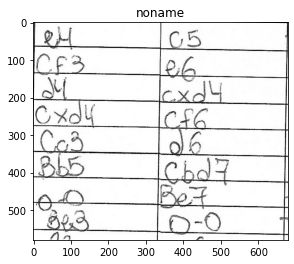

In [9]:
print( label_content[0])
show_image( all_image_content[0])

In [19]:
all_cuts= [c for img in all_image_content for c in cut(img, 8, 2)]
all_labels= [lab for label in label_content for lab in label]

new_cuts= []
new_labels= []
for i in range( 0, len( all_cuts)):
    if 'x' in all_labels[i] or '+' in all_labels[i] or 'cx' in all_labels[i]:
        pass
    else:
        new_cuts.append( all_cuts[i])
        new_labels.append( all_labels[i])

In [20]:
print( len( all_cuts))
print( len( all_labels))
print( len( new_cuts))
print( len( new_labels))

1952
1952
1717
1717


e4


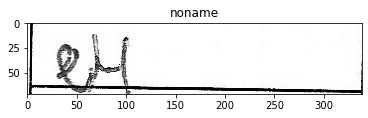

c5


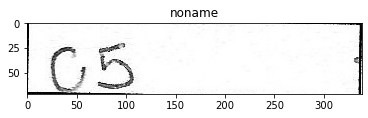

Nf3


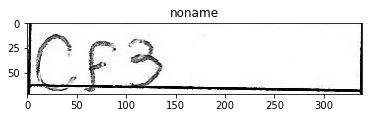

In [21]:
for i in range( 0, 3):
    print( new_labels[i])
    show_image( new_cuts[i])

In [29]:
_dir= path.join( "/mestrado/datasets/carnaval_8lines_shuffle_parts")
for i in range( 0, len( new_labels)):
    f= "part_"+ str(i).zfill(5)+"_" 
    
    write_label( path.join( _dir, "labels", f+new_labels[i].ljust(5, '_')+".pgn"), new_labels[i])
    write_image( path.join( _dir, "images", f+new_labels[i].ljust(5, '_')+".jpg"), new_cuts[i])

In [144]:
LIMIT= 136
N = 10000

IMG_TARGET_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_f_999', 'images')
LABELS_TARGET_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_f_999', 'labels')


all_images, all_image_content, all_labels_files, label_content= _load_all(LIMIT)


all_cuts= [c for img in all_image_content for c in cut(img, 8, 2)]
all_labels= [lab for label in label_content for lab in label]

new_cuts= []
new_labels= []
for i in range( 0, len( all_labels)):
    if 'x' in all_labels[i] or '+' in all_labels[i] or 'c' in all_labels[i]:
        pass
    else:
        new_cuts.append( all_cuts[i])
        new_labels.append( all_labels[i])
        
size= len( new_cuts)
def generate(N):
    count= 0;
    
    for i in range( 0, N):
        id= [np.random.randint(0, size) for _ in range( 0, 16)]
        
        img= rebuild( [new_cuts[j] for j in id])
        label= [new_labels[j] for j in id]
        tag= "shuffle_"+str(i).zfill(5) 
        write_image( os.path.join( IMG_TARGET_DIR, tag+ ".jpg"), resize( img, 50))
        write_label( os.path.join( LABELS_TARGET_DIR, tag+ ".pgn"), " ".join( label))
        if i%500== 0:
            print( i)
            
generate(N)
print( "DONE")

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
DONE
